# Sugestie
* ip embedding
* target encoding
* bucketing
* hash semantyczny
* isolation forest / SVM
* pca



# Przygotowanie danych

In [63]:

from sympy import Integer
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests
import hashlib

## Import danych

In [64]:
# url = 'https://raw.githubusercontent.com/wiktorDeka/WykrywanieAnomalii/main/reduced_dataset_sdn.csv'
url = 'https://raw.githubusercontent.com/wiktorDeka/WykrywanieAnomalii/main/dataset_sdn.csv'
s = requests.get(url).content

counters = pd.read_csv(io.StringIO(s.decode('utf-8')))
counters.dt = pd.to_datetime(counters.dt, unit='s')
counters.set_index('dt', inplace=True)

counters

,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
dt,,,,,,,,,,,,,,,,,,,,,
1970-01-01 03:10:25,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,1943,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1970-01-01 03:13:25,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,1943,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 01:27:42,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,10,...,0,0,ICMP,1,15209,12720,1,1.0,2.0,0
1970-01-01 01:27:42,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,10,...,0,0,ICMP,3,15099,14693,1,1.0,2.0,0
1970-01-01 01:27:42,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,10,...,1,0,ICMP,2,3409,3731,0,0.0,0.0,0


## Przygotowanie danych – brakujące dane

Usunięcie całych obserwacji w których występuje brak danych. Często metodę określa się z angielskiego jako complete-case analysis (CCA), czyli analizie poddajemy tylko te obserwacje dla których mamy pełne dane dla wszystkich zmiennych. W naszym przypadku z uwagi na relatywnie niską liczebność, postanowiliśmy braki pominąć.

In [65]:
counters.dropna(inplace=True)
counters.isnull().sum()


switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64

## Przygotowanie danych - kodowanie zmiennych kategorialnych

Dla przypomnienia zmienna kategorialna to taka, która pozwala na przeprowadzenie klasyfikacji serii danych za pomocą wartości związanych z określoną jakością czy kategorią. Zmienna kategorialna pozwala sklasyfikować, pogrupować w oparciu o informację jakościową, czyli najczęściej w danych spotkamy zmienną kategorialną z elementami stanowiącymi łańcuch tekstowy. W naszym przypadku będziemy zaliczać do zmiennych kategorialnych : data/czas danych wpisów, nazwa protokołu jaki został uzyty, destination i source adresy.

Na podstawie róznych benchamrków, mozemy się skupić na tych 4 enkoderach.

"We observed that four encoders: One-Hot, Binary (‘Bin’ on the plot), Sum, and Weight of Evidence are consistently among the best performing. For logistic regression, the difference of these four from the rest is statistically significant."


## Przygotowanie danych - duration

Łączymy duration_sec i duration_nsec, aby otrzymać pełny czas trwania - duration.


In [66]:
# Create the new 'duration' column

if 'dur' in counters and 'dur_nsec' in counters:
  counters['duration'] = counters['dur'] + counters['dur_nsec'] / 1e9

  # Drop the 'duration_sec' and 'duration_nsec' columns
  counters = counters.drop(['dur', 'dur_nsec'], axis=1)

counters[['duration']].sample(n=10)

,duration
dt,
1970-01-01 02:59:39,166.992
1970-01-01 08:51:13,390.372
1970-01-01 08:43:13,110.518
1970-01-01 07:31:17,291.173
1970-01-01 08:29:42,79.747
1970-01-01 02:02:42,691.472
1970-01-01 08:07:42,310.027
1970-01-01 07:30:47,411.088
1970-01-01 07:41:48,1021.444


## Normalizacja

Normalizacja to proces przekształcania danych wejściowych w taki sposób, aby poprawić wydajność modelu uczącego się. Głównym celem normalizacji jest doprowadzenie danych do jednolitej skali lub rozkładu, co może ułatwić uczenie modelu poprzez zmniejszenie wpływu różnic w zakresach lub jednostkach między różnymi cechami danych.

Istnieje kilka popularnych metod normalizacji danych, takich jak:

Normalizacja min-max: Skaluje wartości cech do zakresu między 0 a 1, wykorzystując minimum i maksimum wartości danej cechy.
Z-score normalization (StandardScaler): Przekształca wartości cech tak, aby miały średnią równą zero i odchylenie standardowe równe jeden.
Normalizacja jednostkowa: Polega na dzieleniu każdej wartości cechy przez normę wektora cechy, co prowadzi do przeskalowania cech do jednostkowego wektora o długości 1.

In [67]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'counters' is your DataFrame
# columns_to_normalize = ['pktcount', 'bytecount', 'tx_bytes', 'rx_bytes']
columns_to_normalize = ['pktcount', 'bytecount', 'tot_dur', 'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate', 'Pairflow', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps', 'duration']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
counters[columns_to_normalize] = scaler.fit_transform(counters[columns_to_normalize])
counters

,switch,src,dst,pktcount,bytecount,tot_dur,flows,packetins,pktperflow,byteperflow,...,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label,duration
dt,,,,,,,,,,,,,,,,,,,,,
1970-01-01 03:10:25,1,10.0.0.1,10.0.0.8,0.174242,0.328245,0.053723,0.066667,0.076883,0.962331,0.996744,...,0.0,UDP,3,1.133295e-01,3.090061e-06,0.000000,0.00000,0.000000,0,0.053531
1970-01-01 03:13:25,1,10.0.0.1,10.0.0.8,0.486123,0.915781,0.149468,0.000000,0.076883,0.962304,0.996717,...,0.0,UDP,4,1.035450e-06,2.689292e-06,0.000000,0.00000,0.000000,0,0.149210
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,0.347427,0.654498,0.106915,0.066667,0.076883,0.962324,0.996737,...,0.0,UDP,1,9.984414e-07,3.896647e-07,0.000000,0.00000,0.000000,0,0.106695
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,0.347427,0.654498,0.106915,0.066667,0.076883,0.962324,0.996737,...,0.0,UDP,2,9.141880e-07,6.420382e-07,0.000000,0.00000,0.000000,0,0.106695
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,0.347427,0.654498,0.106915,0.066667,0.076883,0.962324,0.996737,...,0.0,UDP,3,6.976491e-07,2.835669e-06,0.000000,0.00000,0.000000,0,0.106695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 01:27:42,3,10.0.0.5,10.0.0.7,0.000304,0.000053,0.043533,0.200000,0.000238,0.872365,0.907365,...,0.0,ICMP,1,9.985988e-06,1.197664e-05,0.000049,0.00006,0.000097,0,0.043499
1970-01-01 01:27:42,3,10.0.0.5,10.0.0.7,0.000304,0.000053,0.043533,0.200000,0.000238,0.872365,0.907365,...,0.0,ICMP,3,9.899373e-06,1.396837e-05,0.000049,0.00006,0.000097,0,0.043499
1970-01-01 01:27:42,3,10.0.0.11,10.0.0.5,0.000119,0.000021,0.016918,0.200000,0.000238,0.872371,0.907365,...,0.0,ICMP,2,6.944994e-07,2.902295e-06,0.000000,0.00000,0.000000,0,0.016904


## Target encoding


In [68]:
from sklearn import preprocessing

encoder = preprocessing.TargetEncoder()
src_encoded = encoder.fit_transform(counters[['src']], counters['label'])
counters['src'] = src_encoded
dst_encoded = encoder.fit_transform(counters[['dst']], counters['label'])
counters['dst'] = dst_encoded

counters[['src', 'dst']].sample(n=10)

,src,dst
dt,,
1970-01-01 04:02:35,0.198718,0.240499
1970-01-01 03:08:55,0.392282,0.421725
1970-01-01 03:13:55,0.838077,0.420877
1970-01-01 07:57:48,0.516590,0.434542
1970-01-01 07:05:11,0.198718,0.294367
1970-01-01 09:24:03,0.194022,0.368922
1970-01-01 00:42:58,0.308280,0.457075
1970-01-01 00:52:09,0.192935,0.368908
1970-01-01 07:39:48,0.228365,0.435086


## Hash encoding

Hash encoding to przydatne kodowanie w przypadku dużych zbiorów danych, ponieważ wymaga mniej pamięci niż kodowanie jednokrotne i jest szybsze niż inne techniki kodowania. Kodowanie skrótu odwzorowuje każdą kategorię na unikalną wartość całkowitą w predefiniowanym zakresie przy użyciu funkcji skrótu . Mogą jednak wystąpić kolizje prowadzące do zmniejszenia wydajności modelu. My w naszym przypadku, będziemy hashować adresy ip używając hasha SHA256.

In [69]:
# src_encoded = counters['src'].apply(lambda x: int(hashlib.sha256(str(x).encode('utf-8')).hexdigest(), 16))
# counters['src'] = src_encoded

# dst_encoded = counters['dst'].apply(lambda x: int(hashlib.sha256(str(x).encode('utf-8')).hexdigest(), 16))
# counters['dst'] = dst_encoded

# counters



## Kodowanie One-Hot Encoding/DummyVariable Encoding

Dla zmiennych kategorialnych bez uporządkowania kodowanie numeryczne, a więc określające relację między kategoriami może prowadzić do niewłaściwego działania uczonego modelu. Wymuszenie uporządkowania, tak jak zrobiliśmy to poprzednio też nie jest dobrym rozwiązaniem. Dla takich przypadków stosuje się kodowanie One-Hot Encoding, które w języku polskim określa się jako kodowanie „1 z n”. Poniewaz dane wypisane powyzej mają mieć tylko postać rozróznienia kategorii / grup osoób, skorzystamy z tego kodowanie. W naszym wypadku występuje jednak problem ilości róznych kategorii w odniesieniu do adresów IP

In [70]:
if 'Protocol' in counters:
  usecols = ['Protocol']
  df = counters[usecols]
  # df = df.fillna(value='missing')
  encoded_columns = pd.get_dummies(df, drop_first=False, dtype=int)
  counters = pd.concat([counters, encoded_columns], axis=1)
  counters.drop(columns=usecols, inplace=True)

counters[['Protocol_UDP', 'Protocol_TCP', 'Protocol_ICMP']].sample(n=10)


,Protocol_UDP,Protocol_TCP,Protocol_ICMP
dt,,,
1970-01-01 02:44:36,1,0,0
1970-01-01 02:13:07,0,1,0
1970-01-01 08:32:42,0,0,1
1970-01-01 09:05:03,0,0,1
1970-01-01 09:07:03,0,0,1
1970-01-01 03:13:25,1,0,0
1970-01-01 01:21:47,0,1,0
1970-01-01 00:52:09,1,0,0
1970-01-01 03:15:25,1,0,0


# Wizualizacja

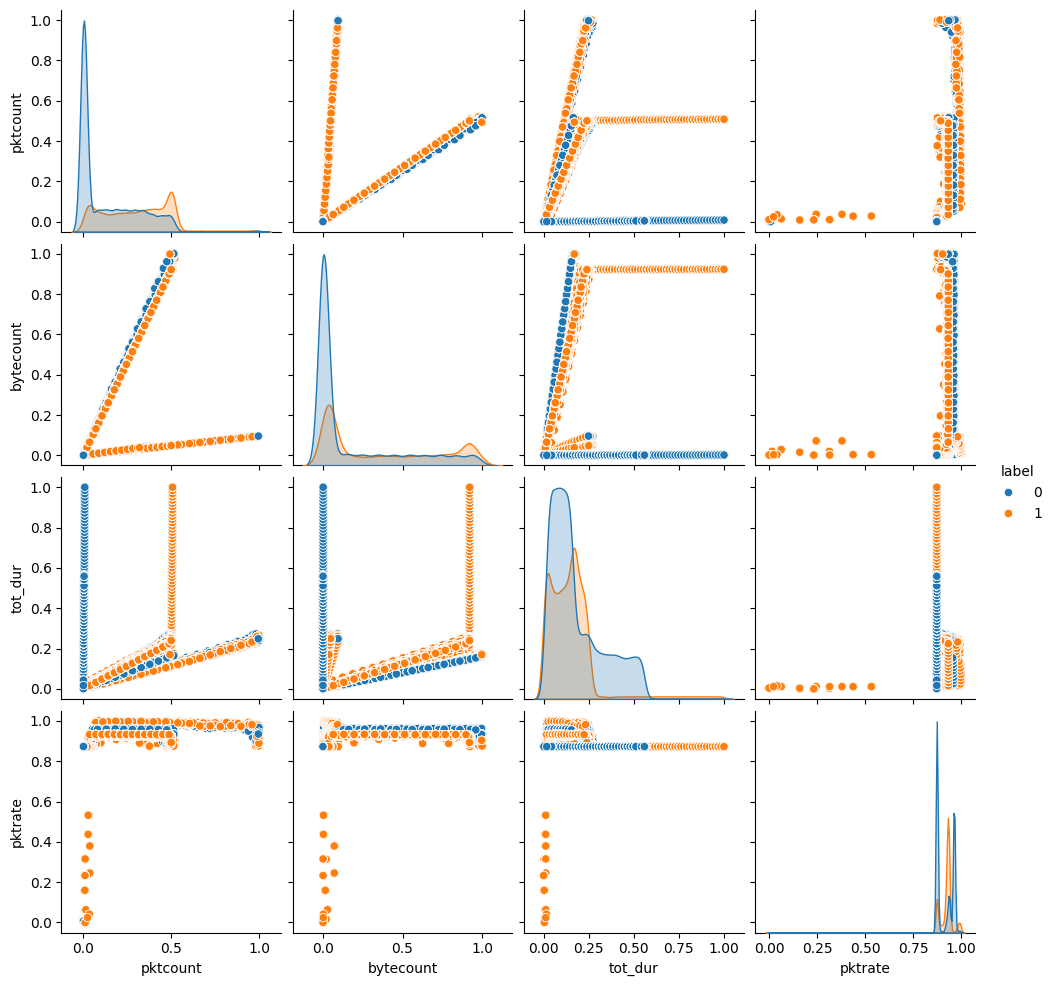

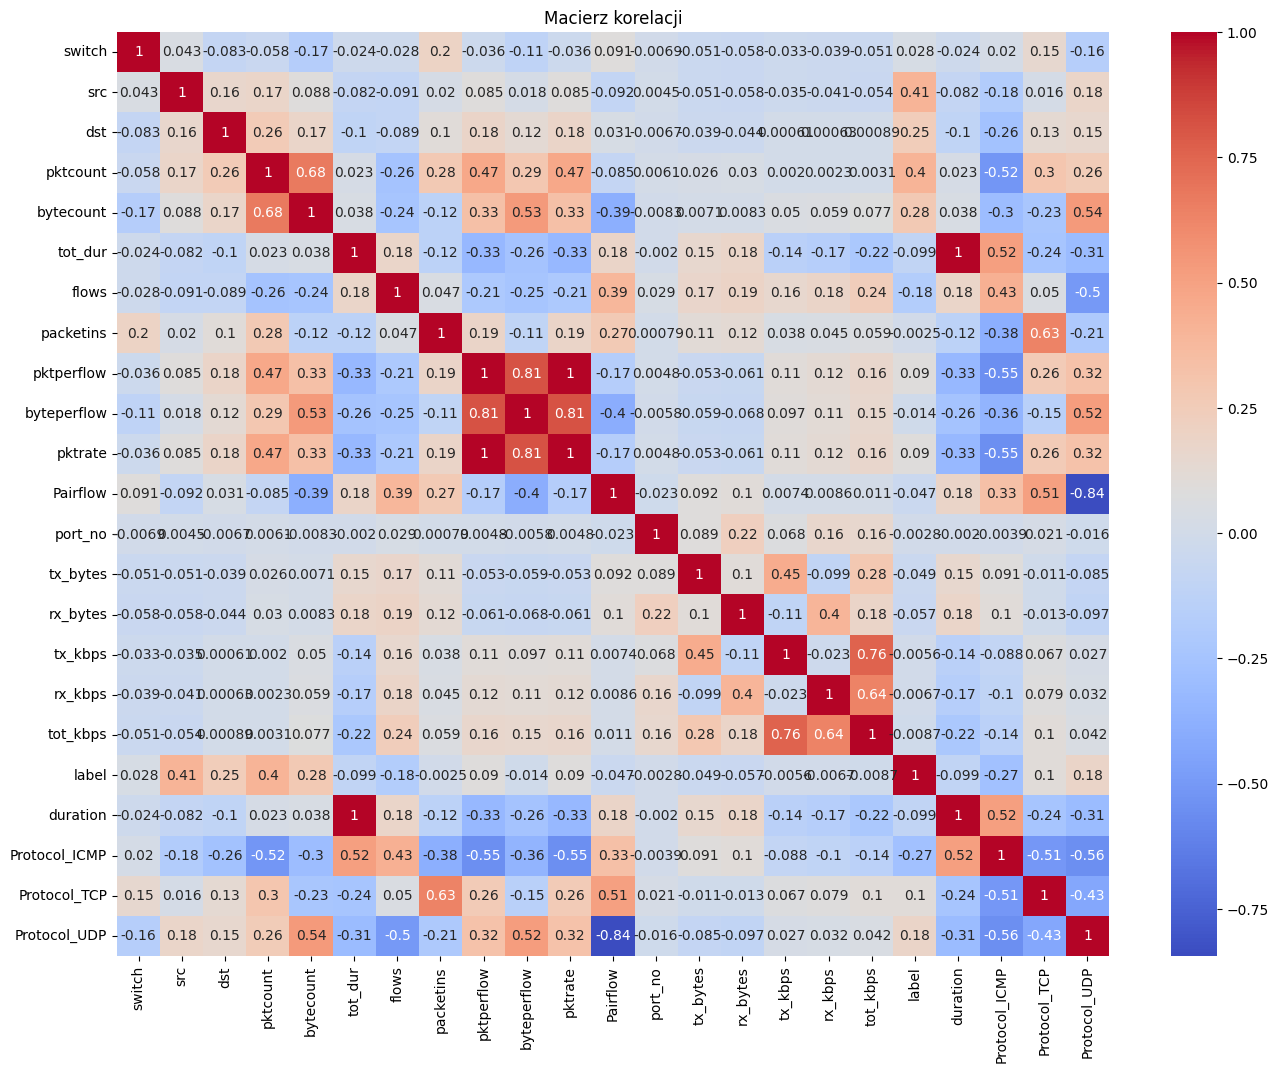

In [71]:
sns.pairplot(counters, hue='label', vars=['pktcount', 'bytecount', 'tot_dur', 'pktrate'])
plt.show()

plt.figure(figsize=(16, 12))
correlation_matrix = counters.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Macierz korelacji')
plt.show()

# Uczenie maszynowe


label
0    63335
1    40504
Name: count, dtype: int64


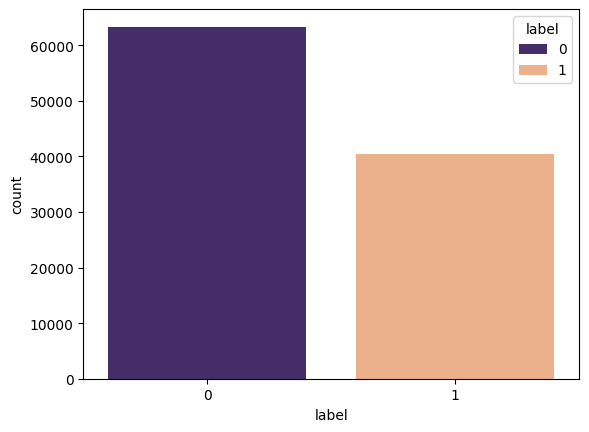

In [72]:
sns.countplot(x=counters['label'], palette=['#432371',"#FAAE7B"], hue=counters['label'])
print(counters['label'].value_counts())

### Podział danych na testowe i treningowe

In [78]:
from sklearn.model_selection import train_test_split

y = counters['label']
X = counters.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## KNN

In [79]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

KNN_train, KNN_test = clf.score(X_train, y_train), clf.score(X_test, y_test)
print(f"Train score: {KNN_train}")
print(f"Test score: {KNN_test}")

# https://github.com/SulemanNavalur/Network-Intrusion-Detection/blob/main/CS.ipynb

# import optuna

# def objective(trial):
#     n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
#     classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
#     classifier_obj.fit(X_train, y_train)
#     accuracy = classifier_obj.score(X_test, y_test)
#     return accuracy

# knn_opt = optuna.create_study(direction='maximize')
# knn_opt.optimize(objective, n_trials=1)

# clf = KNeighborsClassifier(n_neighbors=knn_opt.best_trial.params['KNN_n_neighbors'])
# clf.fit(X_train, y_train)



Train score: 0.9703385749858985
Test score: 0.9527478171545968


## SVM

In [103]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

0.9089304057524397


## Logistic Regression

In [107]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1200000)
clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

0.8072996918335902


# TODO:
* Feature importance
    - Random Forest
* Redukcja wymiarów
    - PCA
* Porównanie modeli
    - SVM, Logistic Regression
    - accuracy, precision, F1-score
* Optymalizacja
    - tuning hiperparametrów
    - walidacja krzyżowa
* NN ???
